In [20]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

In [21]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

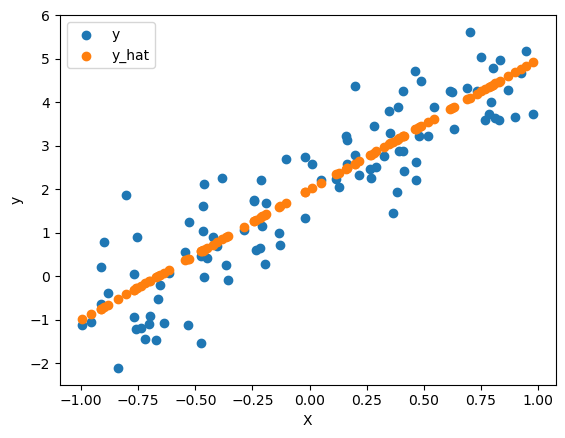

In [22]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

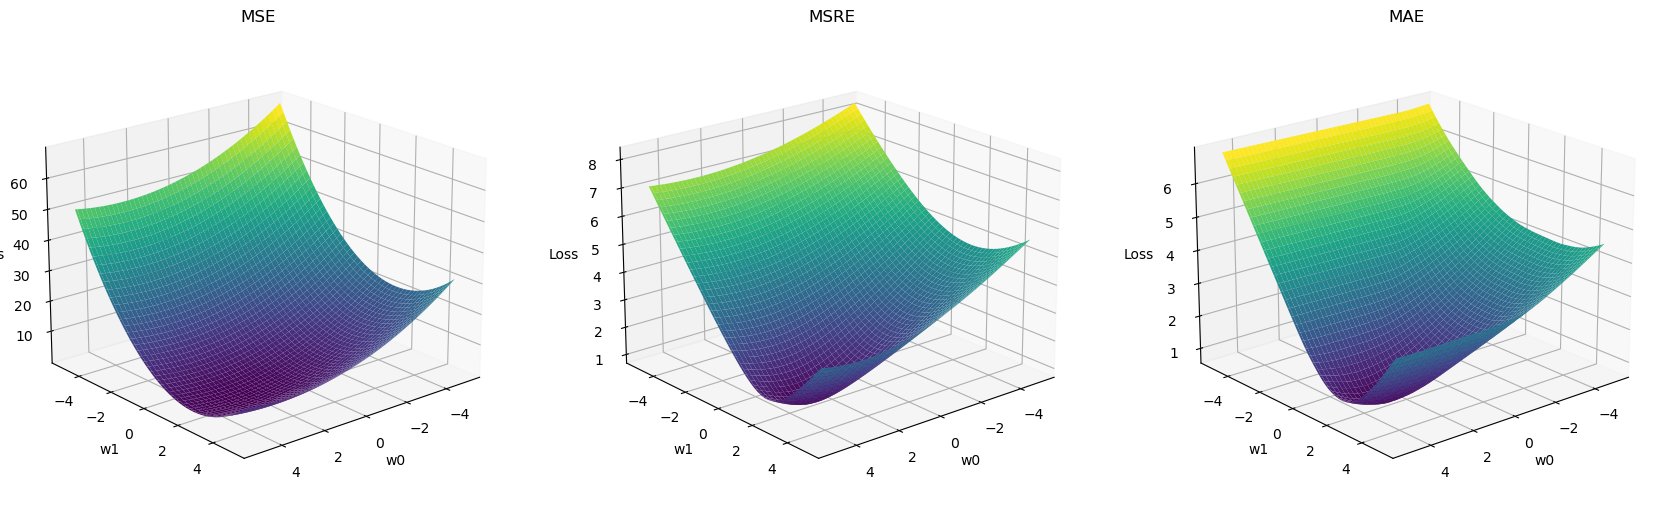

In [23]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [24]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()

In [25]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses

In [26]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

In [27]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [28]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

In [29]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

In [30]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

In [31]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [37]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, betas=(0.9, 0.999)):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.betas = betas
        self.v_t = [torch.zeros(p.shape) for p in self.params]
        self.m_t = [torch.zeros(p.shape) for p in self.params]
        self.counter = 0
        
    def step(self):
        
        self.counter += 1
        
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                
                m_t = self.m_t[i]
                self.m_t[i] = self.betas[0] * m_t + (1 - self.betas[0]) * p.grad
                m_cor = self.m_t[i] / (1 - self.betas[0]**self.counter)
                
                v_t = self.v_t[i]
                self.v_t[i] = self.betas[1] * v_t + (1 - self.betas[1]) * (p.grad ** 2)
                v_cor = self.v_t[i] / (1 - self.betas[1]**self.counter)
                
            
                p -= self.eta * m_cor / (torch.sqrt(v_cor) + self.epsilon)

In [38]:
class AdamW(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, betas=(0.9, 0.999), weight_decay=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.betas = betas
        self.weight_decay = weight_decay
        
        self.v_t = [torch.zeros(p.shape) for p in self.params]
        self.m_t = [torch.zeros(p.shape) for p in self.params]
        self.counter = 0
        
    def step(self):
        self.counter += 1
        
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                
                p -= self.eta * self.weight_decay * p
                
                m_t = self.m_t[i]
                self.m_t[i] = self.betas[0] * m_t + (1 - self.betas[0]) * p.grad
                m_cor = self.m_t[i] / (1 - self.betas[0]**self.counter)
                
                v_t = self.v_t[i]
                self.v_t[i] = self.betas[1] * v_t + (1 - self.betas[1]) * (p.grad ** 2)
                v_cor = self.v_t[i] / (1 - self.betas[1]**self.counter)
                
                p -= self.eta * m_cor / (torch.sqrt(v_cor) + self.epsilon)

In [32]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [16]:
!brew install ffmpeg

==> Fetching downloads for: ffmpeg
==> Downloading https://ghcr.io/v2/homebrew/core/ffmpeg/manifests/8.0_1
######################################################################### 100.0%
==> Fetching dependencies for ffmpeg: brotli, giflib, highway, imath, jpeg-turbo, libpng, xz, lz4, zstd, libtiff, little-cms2, libdeflate, openjph, openexr, webp, jpeg-xl, libvmaf, aom, aribb24, dav1d, freetype, fontconfig, frei0r, gmp, libtasn1, nettle, p11-kit, libevent, libnghttp2, unbound, gnutls, pcre2, glib, xorgproto, libxau, libxdmcp, libxcb, libx11, libxext, libxrender, lzo, pixman, cairo, graphite2, icu4c@77, harfbuzz, lame, fribidi, libunibreak, libass, libudfread, libbluray, cjson, libmicrohttpd, mbedtls, librist, libsoxr, libssh, libvidstab, libogg, libvorbis, libvpx, opencore-amr, openjpeg, opus, rav1e, libsamplerate, flac, mpg123, libsndfile, rubberband, sdl2, snappy, speex, srt, svt-av1, leptonica, libb2, libarchive, pango, tesseract, theora, x264, x265, xvid, libsodium, zeromq and zim

######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libvmaf/manifests/3.0.0-1
######################################################################### 100.0%
==> Fetching libvmaf
==> Downloading https://ghcr.io/v2/homebrew/core/libvmaf/blobs/sha256:0809635a52
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/aom/manifests/3.13.1
######################################################################### 100.0%
==> Fetching aom
==> Downloading https://ghcr.io/v2/homebrew/core/aom/blobs/sha256:ca79133eb9a4ec
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/aribb24/manifests/1.0.4
######################################################################### 100.0%
==> Fetching aribb24
==> Downloading https://ghcr.io/v2/homebrew/core/aribb24/blobs/sha256:4f5a5

######################################################################### 100.0%
==> Fetching libxcb
==> Downloading https://ghcr.io/v2/homebrew/core/libxcb/blobs/sha256:cce8d9e12c3
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libx11/manifests/1.8.12
######################################################################### 100.0%
==> Fetching libx11
==> Downloading https://ghcr.io/v2/homebrew/core/libx11/blobs/sha256:57ccd55767f
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libxext/manifests/1.3.6
######################################################################### 100.0%
==> Fetching libxext
==> Downloading https://ghcr.io/v2/homebrew/core/libxext/blobs/sha256:a0434e871b
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libxrender/mani

######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libssh/manifests/0.11.3
######################################################################### 100.0%
==> Fetching libssh
==> Downloading https://ghcr.io/v2/homebrew/core/libssh/blobs/sha256:ed8b3a5fc47
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libvidstab/manifests/1.1.1
######################################################################### 100.0%
==> Fetching libvidstab
==> Downloading https://ghcr.io/v2/homebrew/core/libvidstab/blobs/sha256:f76b62f
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libogg/manifests/1.3.6
######################################################################### 100.0%
==> Fetching libogg
==> Downloading https://ghcr.io/v2/homebrew/core/libogg/blobs/sha25

######################################################################### 100.0%
==> Fetching libb2
==> Downloading https://ghcr.io/v2/homebrew/core/libb2/blobs/sha256:cc4304b76072
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libarchive/manifests/3.8.1
######################################################################### 100.0%
==> Fetching libarchive
==> Downloading https://ghcr.io/v2/homebrew/core/libarchive/blobs/sha256:33b0775
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/pango/manifests/1.57.0
######################################################################### 100.0%
==> Fetching pango
==> Downloading https://ghcr.io/v2/homebrew/core/pango/blobs/sha256:af46edb4113f
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/tesseract/ma

==> Pouring jpeg-turbo--3.1.2.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/jpeg-turbo/3.1.2: 47 files, 3.6MB
==> Installing ffmpeg dependency: libpng
==> Downloading https://ghcr.io/v2/homebrew/core/libpng/manifests/1.6.50
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/2f04a12c6ccd384325ef3d025d3e5e42fe9cfc1e07c01cd9dd48ad9b57affc4b--libpng-1.6.50.bottle_manifest.json
==> Pouring libpng--1.6.50.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/libpng/1.6.50: 28 files, 1.3MB
==> Installing ffmpeg dependency: xz
==> Downloading https://ghcr.io/v2/homebrew/core/xz/manifests/5.8.1
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/86a115cc1d43ff8a480fd907f812e70a403e1675d8a7223f61bbb08cbd2adc27--xz-5.8.1.bottle_manifest.json
==> Pouring xz--5.8.1.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/xz/5.8.1: 96 files, 2.5MB
==> Installing ffmpeg dependency: lz4
==> Downloading https://ghcr.io/v2/homebrew/core/lz4/manifests/1.10.

==> Pouring frei0r--2.4.0.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/frei0r/2.4.0: 164 files, 5.7MB
==> Installing ffmpeg dependency: gmp
==> Downloading https://ghcr.io/v2/homebrew/core/gmp/manifests/6.3.0
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/70a72a71216843d66a953c06ff6337445ce9bc94fae9f0e301e2f59005274a8e--gmp-6.3.0.bottle_manifest.json
==> Pouring gmp--6.3.0.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/gmp/6.3.0: 22 files, 3.3MB
==> Installing ffmpeg dependency: libtasn1
==> Downloading https://ghcr.io/v2/homebrew/core/libtasn1/manifests/4.20.0
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/0d8e273dbfaade0247db22d4d5abf7e8d4d6c379f7912adc81c60e5d4418e8ca--libtasn1-4.20.0.bottle_manifest.json
==> Pouring libtasn1--4.20.0.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/libtasn1/4.20.0: 63 files, 689.7KB
==> Installing ffmpeg dependency: nettle
==> Downloading https://ghcr.io/v2/homebrew/core/nettle

==> Pouring lzo--2.10.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/lzo/2.10: 32 files, 567.9KB
==> Installing ffmpeg dependency: pixman
==> Downloading https://ghcr.io/v2/homebrew/core/pixman/manifests/0.46.4-1
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/e126e982eb104730948984be72236847b1596aad6f864dd8735e83f5c45520e3--pixman-0.46.4-1.bottle_manifest.json
==> Pouring pixman--0.46.4.arm64_sequoia.bottle.1.tar.gz
🍺  /opt/homebrew/Cellar/pixman/0.46.4: 11 files, 1.4MB
==> Installing ffmpeg dependency: cairo
==> Downloading https://ghcr.io/v2/homebrew/core/cairo/manifests/1.18.4-1
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/20ed33a2e096e765590dfd3f665e6d8f6fbf77fa078113e3acce004e8e53c635--cairo-1.18.4-1.bottle_manifest.json
==> Pouring cairo--1.18.4.arm64_sequoia.bottle.1.tar.gz
🍺  /opt/homebrew/Cellar/cairo/1.18.4: 58 files, 4.5MB
==> Installing ffmpeg dependency: graphite2
==> Downloading https://ghcr.io/v2/homebrew/c

==> Pouring libvidstab--1.1.1.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/libvidstab/1.1.1: 26 files, 190.5KB
==> Installing ffmpeg dependency: libogg
==> Downloading https://ghcr.io/v2/homebrew/core/libogg/manifests/1.3.6
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/2771c95e2ec94043bd81d507b7f5068b581ad45cd1d3529739b5fd47a5031fe8--libogg-1.3.6.bottle_manifest.json
==> Pouring libogg--1.3.6.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/libogg/1.3.6: 103 files, 538.2KB
==> Installing ffmpeg dependency: libvorbis
==> Downloading https://ghcr.io/v2/homebrew/core/libvorbis/manifests/1.3.7-1
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/68d211b8805a2fab148645c2ac8e43495e576876d6f50f0c4af5ea890730b7ea--libvorbis-1.3.7-1.bottle_manifest.json
==> Pouring libvorbis--1.3.7.arm64_sequoia.bottle.1.tar.gz
🍺  /opt/homebrew/Cellar/libvorbis/1.3.7: 158 files, 2.4MB
==> Installing ffmpeg dependency: libvpx
==> Downloading https:

==> Pouring leptonica--1.85.0.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/leptonica/1.85.0: 57 files, 6.9MB
==> Installing ffmpeg dependency: libb2
==> Downloading https://ghcr.io/v2/homebrew/core/libb2/manifests/0.98.1
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/9bb23dca331f0d74876fa5c769113885b92af8a741a851cdfe99f6dfd420b12d--libb2-0.98.1.bottle_manifest.json
==> Pouring libb2--0.98.1.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/libb2/0.98.1: 9 files, 128.8KB
==> Installing ffmpeg dependency: libarchive
==> Downloading https://ghcr.io/v2/homebrew/core/libarchive/manifests/3.8.1
Already downloaded: /Users/aleksejmorozov/Library/Caches/Homebrew/downloads/cdecd3708dbeb69a1dbd1da4d76cf6bd22b9daad143eb0c8daee146d791e5f29--libarchive-3.8.1.bottle_manifest.json
==> Pouring libarchive--3.8.1.arm64_sequoia.bottle.tar.gz
🍺  /opt/homebrew/Cellar/libarchive/3.8.1: 65 files, 3.9MB
==> Installing ffmpeg dependency: pango
==> Downloading https://ghcr.i

In [66]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'Parameter' is not defined

In [1]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

Prepended http:// to 'www.di.ens.fr/~lelarge/MNIST.tar.gz'
--2025-09-28 17:00:22--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Распознаётся www.di.ens.fr (www.di.ens.fr)… 129.199.99.14
Подключение к www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [переход]
--2025-09-28 17:00:22--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Подключение к www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [application/x-gzip]
Сохранение в: «MNIST.tar.gz»

MNIST.tar.gz            [      <=>           ]  33,20M   907KB/s    за 27s     

2025-09-28 17:00:50 (1,22 MB/s) - «MNIST.tar.gz» сохранён [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-im

In [34]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [69]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer
        self.step_count = 0
        if not hasattr(optimizer, 'param_groups'):
            optimizer.param_groups = [{'params': optimizer.params, 'lr': getattr(optimizer, 'lr', getattr(optimizer, 'eta', 0.01))}]
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]
        self._last_lr = self.base_lrs
        
    def get_lr(self):
        raise NotImplementedError
        
        
    def get_last_lr(self):
        return self._last_lr

    def step(self):
        self.step_count += 1
        value = self.get_lr()
        
        for param_group, lr in zip(self.optimizer.param_groups, value):
            param_group["lr"] = lr
            
            if hasattr(self.optimizer, 'lr'):
                self.optimizer.lr = lr
            if hasattr(self.optimizer, 'eta'):
                self.optimizer.eta = lr
        
        self._last_lr = [
            group["lr"] for group in self.optimizer.param_groups
        ]

In [70]:
import math

class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        
    def get_lr(self):
        if self.step_count >= self.total_iters:
            return [group["lr"] for group in self.optimizer.param_groups]
        
        progress = self.step_count / self.total_iters
        factor = self.start_factor + (self.end_factor - self.start_factor) * progress
         
        return [base_lr * factor for base_lr in self.base_lrs]


class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min

    def get_lr(self):
        if self.step_count == 0:
            return self.base_lrs
        
        progress = (self.step_count - 1) / self.T_max
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        
        return [
            self.eta_min + (base_lr - self.eta_min) * cosine_decay 
            for base_lr in self.base_lrs
        ]


Оптимизация - SGD и шедулер - None


SGD_None - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 1: Train Loss: 0.6284, Test Loss: 0.2129, Test accuracy: 93.8200


SGD_None - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 2: Train Loss: 0.1847, Test Loss: 0.1583, Test accuracy: 95.1800


SGD_None - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 3: Train Loss: 0.1337, Test Loss: 0.1111, Test accuracy: 96.6700


SGD_None - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 4: Train Loss: 0.1101, Test Loss: 0.0843, Test accuracy: 97.6300


SGD_None - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 5: Train Loss: 0.0949, Test Loss: 0.0897, Test accuracy: 97.2500


SGD_None - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 6: Train Loss: 0.0841, Test Loss: 0.0755, Test accuracy: 97.6300


SGD_None - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 7: Train Loss: 0.0766, Test Loss: 0.0711, Test accuracy: 97.7600


SGD_None - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 8: Train Loss: 0.0704, Test Loss: 0.0585, Test accuracy: 98.1100


SGD_None - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 9: Train Loss: 0.0653, Test Loss: 0.0555, Test accuracy: 98.3500


SGD_None - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_None Epoch 10: Train Loss: 0.0607, Test Loss: 0.0595, Test accuracy: 98.1200

Оптимизация - SGD и шедулер - LinearLR


SGD_LinearLR - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 1: Train Loss: 0.0570, Test Loss: 0.0542, Test accuracy: 98.2900


SGD_LinearLR - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 2: Train Loss: 0.0528, Test Loss: 0.0533, Test accuracy: 98.2800


SGD_LinearLR - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 3: Train Loss: 0.0497, Test Loss: 0.0468, Test accuracy: 98.5200


SGD_LinearLR - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 4: Train Loss: 0.0470, Test Loss: 0.0465, Test accuracy: 98.4700


SGD_LinearLR - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 5: Train Loss: 0.0450, Test Loss: 0.0422, Test accuracy: 98.6800


SGD_LinearLR - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 6: Train Loss: 0.0428, Test Loss: 0.0477, Test accuracy: 98.4100


SGD_LinearLR - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 7: Train Loss: 0.0417, Test Loss: 0.0476, Test accuracy: 98.4800


SGD_LinearLR - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 8: Train Loss: 0.0400, Test Loss: 0.0422, Test accuracy: 98.6700


SGD_LinearLR - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 9: Train Loss: 0.0388, Test Loss: 0.0403, Test accuracy: 98.6900


SGD_LinearLR - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_LinearLR Epoch 10: Train Loss: 0.0376, Test Loss: 0.0405, Test accuracy: 98.7000

Оптимизация - SGD и шедулер - CosineAnnealing


SGD_CosineAnnealing - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 1: Train Loss: 0.0421, Test Loss: 0.0402, Test accuracy: 98.6400


SGD_CosineAnnealing - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 2: Train Loss: 0.0398, Test Loss: 0.0402, Test accuracy: 98.6300


SGD_CosineAnnealing - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 3: Train Loss: 0.0386, Test Loss: 0.0431, Test accuracy: 98.5200


SGD_CosineAnnealing - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 4: Train Loss: 0.0365, Test Loss: 0.0438, Test accuracy: 98.4300


SGD_CosineAnnealing - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 5: Train Loss: 0.0345, Test Loss: 0.0420, Test accuracy: 98.6600


SGD_CosineAnnealing - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 6: Train Loss: 0.0327, Test Loss: 0.0382, Test accuracy: 98.7200


SGD_CosineAnnealing - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 7: Train Loss: 0.0311, Test Loss: 0.0368, Test accuracy: 98.7600


SGD_CosineAnnealing - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 8: Train Loss: 0.0297, Test Loss: 0.0356, Test accuracy: 98.8100


SGD_CosineAnnealing - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 9: Train Loss: 0.0285, Test Loss: 0.0352, Test accuracy: 98.7800


SGD_CosineAnnealing - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

SGD_CosineAnnealing Epoch 10: Train Loss: 0.0277, Test Loss: 0.0356, Test accuracy: 98.8000

Оптимизация - Adam и шедулер - None


Adam_None - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 1: Train Loss: 0.0702, Test Loss: 0.0525, Test accuracy: 98.2300


Adam_None - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 2: Train Loss: 0.0533, Test Loss: 0.0514, Test accuracy: 98.3800


Adam_None - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 3: Train Loss: 0.0437, Test Loss: 0.0480, Test accuracy: 98.3900


Adam_None - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 4: Train Loss: 0.0368, Test Loss: 0.0476, Test accuracy: 98.5600


Adam_None - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 5: Train Loss: 0.0318, Test Loss: 0.0525, Test accuracy: 98.4000


Adam_None - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 6: Train Loss: 0.0270, Test Loss: 0.0371, Test accuracy: 98.8300


Adam_None - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 7: Train Loss: 0.0239, Test Loss: 0.0317, Test accuracy: 99.0100


Adam_None - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 8: Train Loss: 0.0194, Test Loss: 0.0524, Test accuracy: 98.4400


Adam_None - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 9: Train Loss: 0.0174, Test Loss: 0.0408, Test accuracy: 98.8100


Adam_None - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_None Epoch 10: Train Loss: 0.0172, Test Loss: 0.0406, Test accuracy: 98.8700

Оптимизация - Adam и шедулер - LinearLR


Adam_LinearLR - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 1: Train Loss: 0.0164, Test Loss: 0.0431, Test accuracy: 98.6500


Adam_LinearLR - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 2: Train Loss: 0.0111, Test Loss: 0.0472, Test accuracy: 98.7700


Adam_LinearLR - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 3: Train Loss: 0.0082, Test Loss: 0.0485, Test accuracy: 98.7000


Adam_LinearLR - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 4: Train Loss: 0.0062, Test Loss: 0.0382, Test accuracy: 98.9500


Adam_LinearLR - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 5: Train Loss: 0.0040, Test Loss: 0.0445, Test accuracy: 98.9500


Adam_LinearLR - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 6: Train Loss: 0.0032, Test Loss: 0.0415, Test accuracy: 98.8800


Adam_LinearLR - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 7: Train Loss: 0.0018, Test Loss: 0.0451, Test accuracy: 98.9100


Adam_LinearLR - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 8: Train Loss: 0.0008, Test Loss: 0.0430, Test accuracy: 98.9900


Adam_LinearLR - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 9: Train Loss: 0.0006, Test Loss: 0.0450, Test accuracy: 98.9700


Adam_LinearLR - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_LinearLR Epoch 10: Train Loss: 0.0004, Test Loss: 0.0439, Test accuracy: 99.0200

Оптимизация - Adam и шедулер - CosineAnnealing


Adam_CosineAnnealing - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 1: Train Loss: 0.0083, Test Loss: 0.0488, Test accuracy: 98.8500


Adam_CosineAnnealing - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 2: Train Loss: 0.0078, Test Loss: 0.0590, Test accuracy: 98.7200


Adam_CosineAnnealing - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 3: Train Loss: 0.0080, Test Loss: 0.0524, Test accuracy: 98.8200


Adam_CosineAnnealing - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 4: Train Loss: 0.0043, Test Loss: 0.0606, Test accuracy: 98.7000


Adam_CosineAnnealing - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 5: Train Loss: 0.0053, Test Loss: 0.0569, Test accuracy: 98.9400


Adam_CosineAnnealing - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 6: Train Loss: 0.0073, Test Loss: 0.0592, Test accuracy: 98.6600


Adam_CosineAnnealing - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 7: Train Loss: 0.0043, Test Loss: 0.0516, Test accuracy: 99.0100


Adam_CosineAnnealing - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 8: Train Loss: 0.0063, Test Loss: 0.0561, Test accuracy: 98.8200


Adam_CosineAnnealing - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 9: Train Loss: 0.0046, Test Loss: 0.0536, Test accuracy: 98.9800


Adam_CosineAnnealing - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Adam_CosineAnnealing Epoch 10: Train Loss: 0.0054, Test Loss: 0.0523, Test accuracy: 98.8900

Оптимизация - AdamW и шедулер - None


AdamW_None - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 1: Train Loss: 0.0049, Test Loss: 0.0568, Test accuracy: 98.7800


AdamW_None - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 2: Train Loss: 0.0045, Test Loss: 0.0747, Test accuracy: 98.7200


AdamW_None - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 3: Train Loss: 0.0030, Test Loss: 0.0555, Test accuracy: 98.8900


AdamW_None - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 4: Train Loss: 0.0042, Test Loss: 0.0580, Test accuracy: 98.7500


AdamW_None - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 5: Train Loss: 0.0042, Test Loss: 0.0561, Test accuracy: 98.8700


AdamW_None - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 6: Train Loss: 0.0027, Test Loss: 0.0712, Test accuracy: 98.7200


AdamW_None - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 7: Train Loss: 0.0053, Test Loss: 0.0520, Test accuracy: 98.9200


AdamW_None - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 8: Train Loss: 0.0016, Test Loss: 0.0551, Test accuracy: 98.8900


AdamW_None - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 9: Train Loss: 0.0042, Test Loss: 0.0669, Test accuracy: 98.7600


AdamW_None - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_None Epoch 10: Train Loss: 0.0032, Test Loss: 0.0548, Test accuracy: 98.8900

Оптимизация - AdamW и шедулер - LinearLR


AdamW_LinearLR - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 1: Train Loss: 0.0041, Test Loss: 0.0617, Test accuracy: 98.6600


AdamW_LinearLR - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 2: Train Loss: 0.0010, Test Loss: 0.0503, Test accuracy: 99.0200


AdamW_LinearLR - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 3: Train Loss: 0.0015, Test Loss: 0.0679, Test accuracy: 98.8800


AdamW_LinearLR - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 4: Train Loss: 0.0022, Test Loss: 0.0535, Test accuracy: 98.9100


AdamW_LinearLR - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 5: Train Loss: 0.0006, Test Loss: 0.0541, Test accuracy: 99.0000


AdamW_LinearLR - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 6: Train Loss: 0.0001, Test Loss: 0.0513, Test accuracy: 99.0000


AdamW_LinearLR - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 7: Train Loss: 0.0001, Test Loss: 0.0521, Test accuracy: 99.0100


AdamW_LinearLR - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 8: Train Loss: 0.0000, Test Loss: 0.0519, Test accuracy: 99.0400


AdamW_LinearLR - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 9: Train Loss: 0.0000, Test Loss: 0.0524, Test accuracy: 99.0300


AdamW_LinearLR - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_LinearLR Epoch 10: Train Loss: 0.0000, Test Loss: 0.0524, Test accuracy: 99.0200

Оптимизация - AdamW и шедулер - CosineAnnealing


AdamW_CosineAnnealing - Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 1: Train Loss: 0.0032, Test Loss: 0.0593, Test accuracy: 99.0000


AdamW_CosineAnnealing - Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 2: Train Loss: 0.0023, Test Loss: 0.0573, Test accuracy: 98.9200


AdamW_CosineAnnealing - Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 3: Train Loss: 0.0007, Test Loss: 0.0618, Test accuracy: 98.7000


AdamW_CosineAnnealing - Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 4: Train Loss: 0.0058, Test Loss: 0.0492, Test accuracy: 99.0100


AdamW_CosineAnnealing - Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 5: Train Loss: 0.0011, Test Loss: 0.0555, Test accuracy: 98.9500


AdamW_CosineAnnealing - Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 6: Train Loss: 0.0016, Test Loss: 0.0683, Test accuracy: 98.6500


AdamW_CosineAnnealing - Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 7: Train Loss: 0.0054, Test Loss: 0.0535, Test accuracy: 98.9000


AdamW_CosineAnnealing - Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 8: Train Loss: 0.0024, Test Loss: 0.0590, Test accuracy: 98.9200


AdamW_CosineAnnealing - Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 9: Train Loss: 0.0012, Test Loss: 0.0622, Test accuracy: 98.8300


AdamW_CosineAnnealing - Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

AdamW_CosineAnnealing Epoch 10: Train Loss: 0.0030, Test Loss: 0.0555, Test accuracy: 98.8200


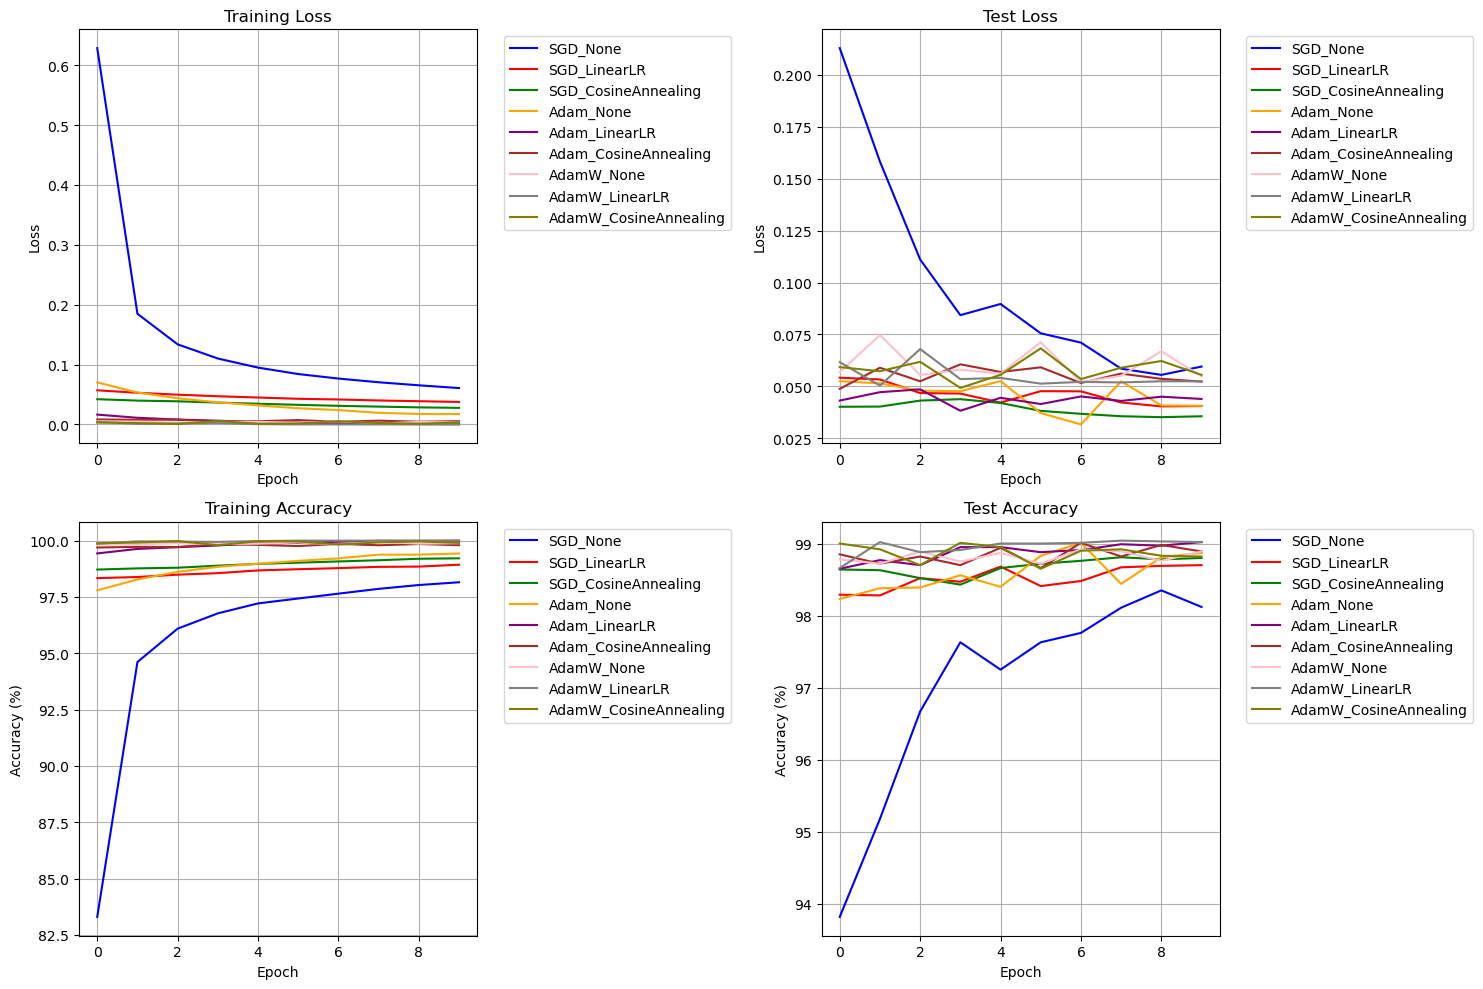

Optimizer | Scheduler       | Final Train Acc (%) | Final Test Acc (%)
SGD       | None            |            98.15 |            98.12
SGD       | LinearLR        |            98.93 |            98.70
SGD       | CosineAnnealing |            99.22 |            98.80
Adam      | None            |            99.43 |            98.87
Adam      | LinearLR        |           100.00 |            99.02
Adam      | CosineAnnealing |            99.80 |            98.89
AdamW     | None            |            99.89 |            98.89
AdamW     | LinearLR        |           100.00 |            99.02
AdamW     | CosineAnnealing |            99.90 |            98.82

Лучшее комбо: Adam_LinearLR, где Accuracy = 99.02%


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from collections import defaultdict


# Выбрал модель из ДЗ 3
model_NL = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Функция для обучения модели
def train_model(optimizer_name, scheduler_name, train_loader, test_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_NL.to(device)
    
    if optimizer_name == 'SGD':
        optimizer = SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adam':
        optimizer = Adam(model.parameters(), eta=0.001)
    elif optimizer_name == 'AdamW':
        optimizer = AdamW(model.parameters(), eta=0.001, weight_decay=0.01)
    
    if scheduler_name == 'None':
        scheduler = None
    elif scheduler_name == 'LinearLR':
        scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=epochs)
    elif scheduler_name == 'CosineAnnealing':
        scheduler = CosineAnnealing(optimizer, T_max=epochs, eta_min=0.001)
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    learning_rates = []
    
    for epoch in range(epochs):
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'{optimizer_name}_{scheduler_name} - Epoch {epoch+1}/{epochs}', leave=False)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = torch.max(output.data, 1)[1]
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        if hasattr(optimizer, 'param_groups'):
            current_lr = optimizer.param_groups[0]['lr']
        elif hasattr(optimizer, 'lr'):
            current_lr = optimizer.lr
        elif hasattr(optimizer, 'eta'):
            current_lr = optimizer.eta
        else:
            current_lr = 0.01
            
        learning_rates.append(current_lr)
        
        if scheduler:
            scheduler.step()
        
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                predicted = torch.max(output.data, 1)[1]
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'{optimizer_name}_{scheduler_name} Epoch {epoch+1}: '
            f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
            f'Test accuracy: {test_accuracy:.4f}')
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'learning_rates': learning_rates,
        'final_train_accuracy': train_accuracies[-1],
        'final_test_accuracy': test_accuracies[-1]
    }

# 9 тестов подряд
optimizers = ['SGD', 'Adam', 'AdamW']
schedulers = ['None', 'LinearLR', 'CosineAnnealing']
epochs = 10

results = {}

for optimizer in optimizers:
    for scheduler in schedulers:
        print(f"\nОптимизация - {optimizer} и шедулер - {scheduler}")
        key = f"{optimizer}_{scheduler}"
        results[key] = train_model(optimizer, scheduler, train_loader, test_loader, epochs)

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

# Графики потерь трейн
for idx, (key, color) in enumerate(zip(results.keys(), colors)):
    axes[0, 0].plot(results[key]['train_losses'], label=key, color=color)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True)

# Графики потерь тест
for idx, (key, color) in enumerate(zip(results.keys(), colors)):
    axes[0, 1].plot(results[key]['test_losses'], label=key, color=color)
axes[0, 1].set_title('Test Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True)

# Графики точности трейн
for idx, (key, color) in enumerate(zip(results.keys(), colors)):
    axes[1, 0].plot(results[key]['train_accuracies'], label=key, color=color)
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True)

# Графики точности тест
for idx, (key, color) in enumerate(zip(results.keys(), colors)):
    axes[1, 1].plot(results[key]['test_accuracies'], label=key, color=color)
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


print("Optimizer | Scheduler       | Final Train Acc (%) | Final Test Acc (%)")
for optimizer in optimizers:
    for scheduler in schedulers:
        key = f"{optimizer}_{scheduler}"
        train_acc = results[key]['final_train_accuracy']
        test_acc = results[key]['final_test_accuracy']
        print(f"{optimizer:9} | {scheduler:15} | {train_acc:16.2f} | {test_acc:16.2f}")

# Выявление топ комбинации
best_test_acc = 0
best_combo = ""
for key, result in results.items():
    if result['final_test_accuracy'] > best_test_acc:
        best_test_acc = result['final_test_accuracy']
        best_combo = key

print(f"\nЛучшее комбо: {best_combo}, где Accuracy = {best_test_acc:.2f}%")